In [1]:
import numpy as np
import requests
import pandas as pd
from cStringIO import StringIO
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


In [2]:
catalogType = "Berger2019"
# catalogType = "Burke"

doRadCut = False

Import the base DR25 catalog from the exoplanet archive

In [3]:
if False:
    urlstellar = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_stellar&select=*"

    r = requests.get(urlstellar)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Stellar = pd.read_csv(fh, dtype={"st_quarters":str})
    dr25Stellar.to_csv("stellarCatalogs/dr25_stellar_archive.txt", index=False)
else:
    dr25Stellar = pd.read_csv("stellarCatalogs/dr25_stellar_archive.txt", dtype={"st_quarters":str})



Import the DR25 supplemental catalog

In [4]:
if False:
    urlsupp = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_supp_stellar&select=*"
    r = requests.get(urlsupp)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25StellarSup = pd.read_csv(fh, dtype={"st_quarters":str})
    dr25StellarSup.to_csv("stellarCatalogs/dr25_stellar_supp_archive.txt", index=False)
else:
    dr25StellarSup = pd.read_csv("stellarCatalogs/dr25_stellar_supp_archive.txt", dtype={"st_quarters":str})


Merge the two catalogs.  The supplemental catalog has fewer entries, so we have to be careful about the merge.  The merged catalog has the same number of entries as the supplemental catalog.

In [5]:
# merging with inner gives the intersection of kepids
mergedDr25Stellar = pd.merge(dr25Stellar, dr25StellarSup, on="kepid", how="inner")
# get the original column names
sColumns = list(dr25Stellar)


Because both catalogs share column names, mergedStellar has a column for each catalog, with the column names given an "\_x" for the stellar catalog and "\_y" for the supplemental.  We have to reconcile this by 
    a) restoring the original names, 
    b) copying the values in the supplemental catalog to the stellar columns for those columns specified in the supplemental documentation, and 
    c) removing the supplemental colums.

In [6]:

suppColNames = [ "kepid","teff","teff_err1","teff_err2","logg","logg_err1","logg_err2","feh","feh_err1","feh_err2","radius","radius_err1","radius_err2","mass","mass_err1","mass_err2","dens","dens_err1","dens_err2","dist","dist_err1","dist_err2","av","av_err1","av_err2","prov_sec" ]

# first copy all the stellar paratmers to their original names
for i in range(1,len(sColumns)):
    mergedDr25Stellar[sColumns[i]] = mergedDr25Stellar[sColumns[i]+"_x"]
# now overwrite using the new columns (from Savita's erratum file)
for i in range(1,len(suppColNames)):
    mergedDr25Stellar[suppColNames[i]] = mergedDr25Stellar[suppColNames[i]+"_y"]
# drop the doubled columns
for i in range(1,len(sColumns)):
    mergedDr25Stellar = mergedDr25Stellar.drop([sColumns[i]+"_x", sColumns[i]+"_y"], axis=1)
print("the merged catalog has " + str(len(mergedDr25Stellar)) + " entries")



the merged catalog has 197096 entries


Save the merged catalog.

In [7]:
mergedDr25Stellar.to_csv("stellarCatalogs/dr25_stellar_updated_feh.txt", index=False)

Now restore the entries in the original stellar catalog that are not in the supplemental catalog.  First we identify the original-only entries by repeating the merge, then entries in the merge from the stellar table.  Then we concat the remaining entries with the merged table.  Finally we save the final full table.

In [8]:
# now get the stars not in the stellar_supp by dropping stars in the merge from stellar (using reset index)
merge2 = pd.merge(dr25Stellar.reset_index(), dr25StellarSup, on="kepid", how="inner")
dr25StellarNoSup = dr25Stellar.drop(merge2["index"])

# now concat the merged set and the non-supp stars
dr25StellarFullMerged = pd.concat([mergedDr25Stellar, dr25StellarNoSup])

# print(list(stellar_full_merged))
print("the final catalog has " + str(len(dr25StellarFullMerged)) + " entries")

dr25StellarFullMerged.to_csv("stellarCatalogs/dr25_stellar_updated_feh_all.txt", index=False)



the final catalog has 200038 entries


Next we bring in the Gaia-derived properties from Berger et. al. (http://adsabs.harvard.edu/abs/2018ApJ...866...99B).  This provides improved radii and distances.  It also includes effective temperatures that differ from the DR25 catalog, but we believe the DR25 catalog's effectiv temperatures are more reliable. The Berger table has 177,911 entries, and we will restrict our analysis to the stellar population in the Berger table.

In [9]:
from astropy.io import ascii

# read the publised table from Berger et. al. 
gaiaUpdates = ascii.read("stellarCatalogs/apj_table1_published.txt")

gaiaUpdatesPd = gaiaUpdates.to_pandas();
dr25GaiaStellar = pd.merge(dr25StellarFullMerged, gaiaUpdatesPd, left_on="kepid", right_on="KIC", how="inner")

# copy the dr25 distance and radius to renamed columns in case anyone wants to compare
dr25GaiaStellar["dist_DR25"] = dr25GaiaStellar["dist"]
dr25GaiaStellar["dist_DR25_err1"] = dr25GaiaStellar["dist_err1"]
dr25GaiaStellar["dist_DR25_err2"] = dr25GaiaStellar["dist_err2"]

dr25GaiaStellar["radius_DR25"] = dr25GaiaStellar["radius"]
dr25GaiaStellar["radius_DR25_err1"] = dr25GaiaStellar["radius_err1"]
dr25GaiaStellar["radius_DR25_err2"] = dr25GaiaStellar["radius_err2"]

# copy Gaia distance to the dr25 distance column
dr25GaiaStellar["dist"] = dr25GaiaStellar["D"]
# for DR25, err1 is the upper uncertainty, err2 is the lower uncertainty and is < 0
# for Gaia, E_D is the upper uncertainty, E_d is the lower uncertainty and is > 0
dr25GaiaStellar["dist_err1"] = dr25GaiaStellar["E_D"]
dr25GaiaStellar["dist_err2"] = -dr25GaiaStellar["e_D"]
# copy Gaia radius to the dr25 radius column
dr25GaiaStellar["radius"] = dr25GaiaStellar["R*"]
# for DR25, err1 is the upper uncertainty, err2 is the lower uncertainty and is < 0
# for Gaia, E_R* is the upper uncertainty, E_R* is the lower uncertainty and is > 0
dr25GaiaStellar["radius_err1"] = dr25GaiaStellar["E_R*"]
dr25GaiaStellar["radius_err2"] = -dr25GaiaStellar["e_R*"]

# we'll leave the Gaia columns in place because they have different names
print("the gaia/Berger catalog has " + str(len(dr25GaiaStellar)) + " entries")

dr25GaiaStellar.to_csv("stellarCatalogs/dr25_stellar_supp_gaia.txt", index=False)

the gaia/Berger catalog has 177911 entries


In [10]:
travisStellar = pd.read_csv("stellarCatalogs/ALL_KEPLER_GRID_PARS_GK_FIXED_MANNMODELS.csv", dtype={"band":str})

travisColNames = [ "id_starname","iso_rad","iso_rad_err1","iso_rad_err2","iso_logg","iso_logg_err1","iso_logg_err2",
                "iso_feh","iso_feh_err1","iso_feh_err2","iso_teff","iso_teff_err1","iso_teff_err2",
                "iso_mass","iso_mass_err1","iso_mass_err2","iso_rho","iso_rho_err1","iso_rho_err2",
                "dist","dist_err1","dist_err2","iso_avs","iso_avs_err1","iso_avs_err2" ]

# remove items not in travisColNames
for colName in list(travisStellar):
    if not colName in travisColNames:
        travisStellar = travisStellar.drop(colName, axis=1)
# extract the integer kepid from the starname
iso_kepid = np.zeros((len(travisStellar),), dtype=np.int)
for i in range(len(travisStellar)):
    iso_kepid[i] = int(travisStellar["id_starname"][i][3:])

travisStellar["iso_kepid"] = iso_kepid
travisStellar = travisStellar.drop("id_starname", axis=1)



In [11]:
dr25GaiaStellar = pd.merge(dr25GaiaStellar, travisStellar, left_on="kepid", right_on="iso_kepid", how="inner")

# copy the dr25 distance and radius to renamed columns in case anyone wants to compare
dr25GaiaStellar["teff_DR25"] = dr25GaiaStellar["teff"]
dr25GaiaStellar["teff_DR25_err1"] = dr25GaiaStellar["teff_err1"]
dr25GaiaStellar["teff_DR25_err2"] = dr25GaiaStellar["teff_err2"]

dr25GaiaStellar["logg_DR25"] = dr25GaiaStellar["logg"]
dr25GaiaStellar["logg_DR25_err1"] = dr25GaiaStellar["logg_err1"]
dr25GaiaStellar["logg_DR25_err2"] = dr25GaiaStellar["logg_err2"]

dr25GaiaStellar["feh_DR25"] = dr25GaiaStellar["feh"]
dr25GaiaStellar["feh_DR25_err1"] = dr25GaiaStellar["feh_err1"]
dr25GaiaStellar["feh_DR25_err2"] = dr25GaiaStellar["feh_err2"]

# copy isochrone data to the dr25 data columns
dr25GaiaStellar["logg"] = dr25GaiaStellar["iso_logg"]
dr25GaiaStellar["logg_err1"] = dr25GaiaStellar["iso_logg_err1"]
dr25GaiaStellar["logg_err2"] = -dr25GaiaStellar["iso_logg_err2"]

dr25GaiaStellar["teff"] = dr25GaiaStellar["iso_teff"]
dr25GaiaStellar["teff_err1"] = dr25GaiaStellar["iso_teff_err1"]
dr25GaiaStellar["teff_err2"] = -dr25GaiaStellar["iso_teff_err2"]

dr25GaiaStellar["radius"] = dr25GaiaStellar["iso_rad"]
dr25GaiaStellar["radius_err1"] = dr25GaiaStellar["iso_rad_err1"]
dr25GaiaStellar["radius_err2"] = -dr25GaiaStellar["iso_rad_err2"]

dr25GaiaStellar["feh"] = dr25GaiaStellar["iso_feh"]
dr25GaiaStellar["feh_err1"] = dr25GaiaStellar["iso_feh_err1"]
dr25GaiaStellar["feh_err2"] = -dr25GaiaStellar["iso_feh_err2"]

# now we have to correct the DR25 limb darkening coefficients
# by linearly interpolating the table from Claret and Boemen
# this takes several minutes

dr25GaiaStellar["limbdark_coeff1_DR25"] = dr25GaiaStellar["limbdark_coeff1"]
dr25GaiaStellar["limbdark_coeff2_DR25"] = dr25GaiaStellar["limbdark_coeff2"]
dr25GaiaStellar["limbdark_coeff3_DR25"] = dr25GaiaStellar["limbdark_coeff3"]
dr25GaiaStellar["limbdark_coeff4_DR25"] = dr25GaiaStellar["limbdark_coeff4"]

limbDarkeningTable= pd.read_csv("stellarCatalogs/claretBoemenTableEqn5Kepler.txt", delim_whitespace=True)

ldParams = np.transpose(np.array((limbDarkeningTable.logg.values,
                                  limbDarkeningTable.teff.values,
                                  limbDarkeningTable.feh.values)))

starParams = np.transpose(np.array((dr25GaiaStellar.logg.values, 
              dr25GaiaStellar.teff.values, 
              dr25GaiaStellar.feh.values)))

dr25GaiaStellar["limbdark_coeff1"] = griddata(ldParams, limbDarkeningTable.a1.values, starParams)
dr25GaiaStellar["limbdark_coeff2"] = griddata(ldParams, limbDarkeningTable.a2.values, starParams)
dr25GaiaStellar["limbdark_coeff3"] = griddata(ldParams, limbDarkeningTable.a3.values, starParams)
dr25GaiaStellar["limbdark_coeff4"] = griddata(ldParams, limbDarkeningTable.a4.values, starParams)

# we'll leave the Gaia columns in place because they have different names
print("the Berger2019 catalog has " + str(len(dr25GaiaStellar)) + " entries")


dr25GaiaStellar.to_csv("stellarCatalogs/dr25_stellar_supp_gaia_logg.txt", index=False)

    

the Berger2019 catalog has 175828 entries


dr25_stellar_supp_gaia_logg.txt is our base catalog.  We now apply several cuts to restrict our occurrence rate analysis to targets for which we have reliable completeness information, following the guidelines in Section 3.6 of https://exoplanetarchive.ipac.caltech.edu/docs/KSCI-19111-002.pdf.

In [12]:
cleanDr25GaiaStellar = dr25GaiaStellar

First we remove the stars marked binary due to Gaia radius (Bin = 1 or 3) or evolved (Evol > 0).  We do not remove targets with AO companions (Bin = 2) because the target star population was not uniformly surveyed with AO.  We expect few evolved stars because most should have been removed by the R <= 1.25 cut.



In [13]:
from evolstate_lib import evolstate

if (catalogType == "Berger2019"):
    binaryDr25GaiaStellar = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.Bin == 1)|(cleanDr25GaiaStellar.Bin == 3)]
    if catalogType == "Berger2019":
        binaryDr25GaiaStellar.to_csv("stellarCatalogs/dr25_stellar_supp_gaia_binaries.txt", index=False)
    print("There are " + str(len(binaryDr25GaiaStellar)) + " targets with binary flag == 1 or 3")

    cleanDr25GaiaStellar["Evol"] = evolstate.evolstate(cleanDr25GaiaStellar.teff.values, 
                                                       cleanDr25GaiaStellar.radius.values, cleanDr25GaiaStellar.logg.values)
    evolvedDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.Evol > 0]
    if catalogType == "Berger2019":
        evolvedDr25GaiaStellar.to_csv("stellarCatalogs/dr25_stellar_supp_gaia_evolved.txt", index=False)
    print("There are " + str(len(evolvedDr25GaiaStellar)) + " targets with evolved flag > 0")

    cleanDr25GaiaStellar = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.Bin == 0)|(cleanDr25GaiaStellar.Bin == 2)]
    print(str(len(cleanDr25GaiaStellar)) + " entries after removing marked binaries")
    cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.Evol == 0]
    print(str(len(cleanDr25GaiaStellar)) + " entries after removing marked evolved stars")



There are 1853 targets with binary flag == 1 or 3
There are 64982 targets with evolved flag > 0
173975 entries after removing marked binaries
109083 entries after removing marked evolved stars


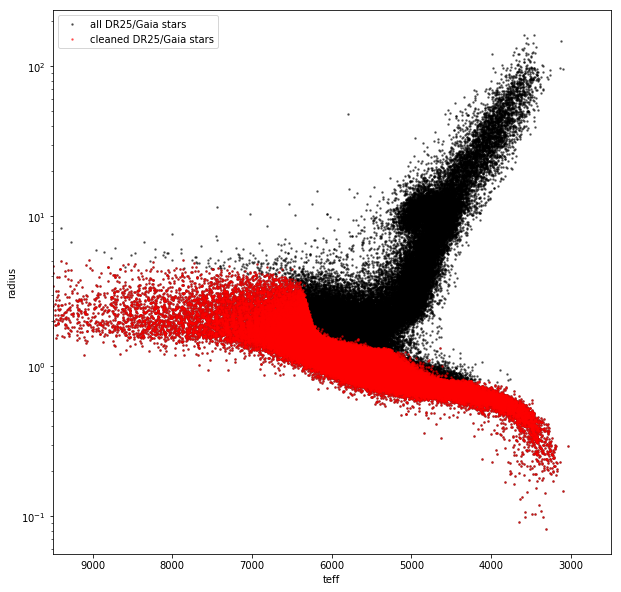

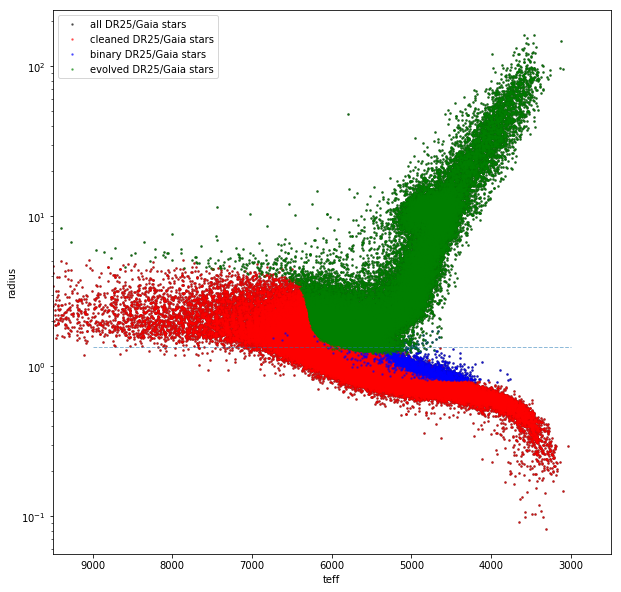

In [14]:
plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellar.teff, cleanDr25GaiaStellar["R*"], ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars"));
plt.ylabel("radius");
plt.xlabel("teff");

if (catalogType == "Berger2019"):
    plt.figure(figsize=(10,10));
    plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
    plt.semilogy(cleanDr25GaiaStellar.teff, cleanDr25GaiaStellar["R*"], ".r", ms=3, alpha=0.5)
    plt.semilogy(binaryDr25GaiaStellar.teff, binaryDr25GaiaStellar["R*"], ".b", ms=3, alpha=0.5)
    plt.semilogy(evolvedDr25GaiaStellar.teff, evolvedDr25GaiaStellar["R*"], ".g", ms=3, alpha=0.5)
    plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
    plt.xlim(9500, 2500)
    plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars", "binary DR25/Gaia stars", "evolved DR25/Gaia stars"));
    plt.ylabel("radius");
    plt.xlabel("teff");


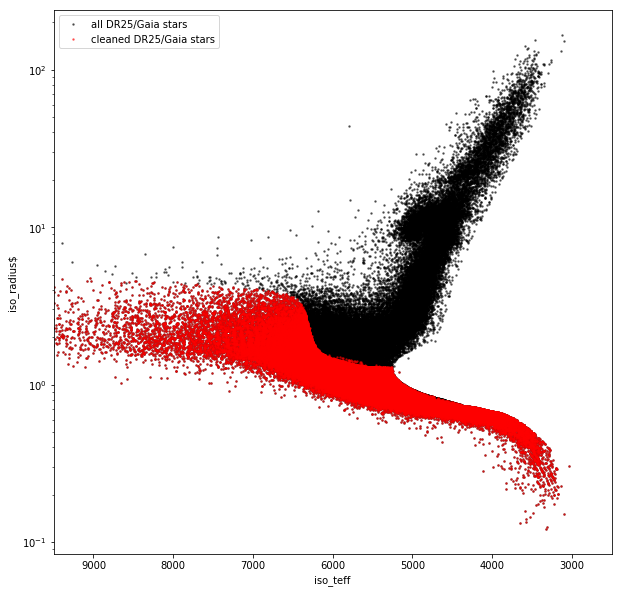

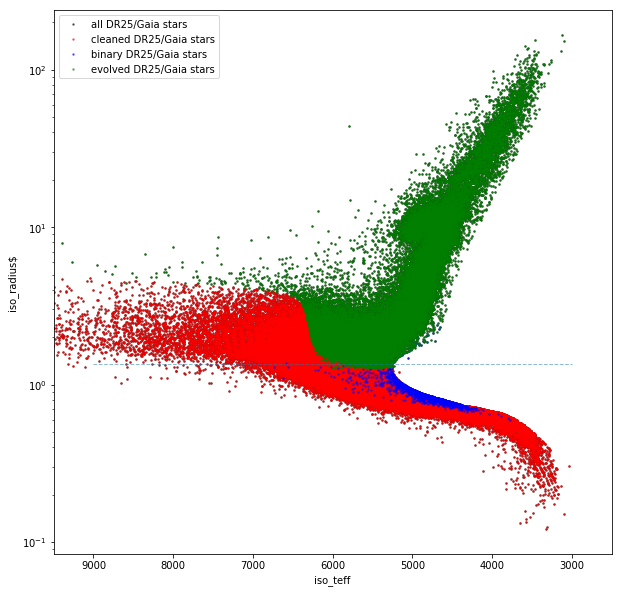

In [15]:
plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.iso_teff, dr25GaiaStellar.iso_rad, ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellar.iso_teff, cleanDr25GaiaStellar.iso_rad, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars"));
plt.ylabel("iso_radius$");
plt.xlabel("iso_teff");

if (catalogType == "Berger2019"):
    plt.figure(figsize=(10,10));
    plt.semilogy(dr25GaiaStellar.iso_teff, dr25GaiaStellar.iso_rad, ".k", ms=3, alpha=0.5)
    plt.semilogy(cleanDr25GaiaStellar.iso_teff, cleanDr25GaiaStellar.iso_rad, ".r", ms=3, alpha=0.5)
    plt.semilogy(binaryDr25GaiaStellar.iso_teff, binaryDr25GaiaStellar.iso_rad, ".b", ms=3, alpha=0.5)
    plt.semilogy(evolvedDr25GaiaStellar.iso_teff, evolvedDr25GaiaStellar.iso_rad, ".g", ms=3, alpha=0.5)
    plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
    plt.xlim(9500, 2500)
    plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars", "binary DR25/Gaia stars", "evolved DR25/Gaia stars"));
    plt.ylabel("iso_radius$");
    plt.xlabel("iso_teff");


Next we remove stars that are on the list https://github.com/nasa/KeplerPORTs/blob/master/DR25_DEModel_NoisyTargetList.txt.

In [16]:
noisyTargets = pd.read_csv("data/DR25_DEModel_NoisyTargetList.txt", header=9)
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~dr25GaiaStellar.kepid.isin(noisyTargets['# 1- Kepler ID'])]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing noisy targets")

107411 entries after removing noisy targets


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Next we remove stars with radii > 1.35 Rsun (to match what Chris is currently doing - the KSCI recommends 1.25 Rsun).

In [17]:
if doRadCut:
    cleanDr25GaiaStellar = cleanDr25GaiaStellar[dr25GaiaStellar.radius <= 1.35]
    print(str(len(cleanDr25GaiaStellar)) + " entries after removing R>1.35 targets")


Next we remove stars with nan limb darkening coefficients.

In [18]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff1)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff2)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff3)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff4)]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing Nan limb darkening targets")


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


106936 entries after removing Nan limb darkening targets


Next we remove stars with duty cycle = nan.

In [19]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.dutycycle)]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing Nan dutycycle targets")


106463 entries after removing Nan dutycycle targets


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Next we remove stars that have had a drop in duty cycle > 30% due to the removal of transits. (10% in KSCI)

In [20]:
dutyCycleChange = cleanDr25GaiaStellar.dutycycle - cleanDr25GaiaStellar.dutycycle_post
cleanDr25GaiaStellar = cleanDr25GaiaStellar[dutyCycleChange/cleanDr25GaiaStellar.dutycycle <= 0.3]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing duty cycle drops > 0.3")


101797 entries after removing duty cycle drops > 0.3


Next we remove stars that have duty cycles < 0.6.

In [21]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.dutycycle >= 0.6]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with duty cycle < 0.6")

98381 entries after removing after removing stars with duty cycle < 0.6


Next we remove stars with data span < 1000

In [22]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.dataspan >= 1000]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with data span < 1000")

90873 entries after removing after removing stars with data span < 1000


Next we remove stars with the timeoutsumry flag != 1.

In [23]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.timeoutsumry == 1]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with timeoutsumry != 1")

85165 entries after removing after removing stars with timeoutsumry != 1


In [24]:
if catalogType == "Berger2019":
    catalogHeader = "dr25_stellar_supp_gaia_clean"
elif catalogType == "Burke":
    catalogHeader = "dr25_stellar_supp_burke_clean"
    
if doRadCut:
    catalogHeader = catalogHeader + "_radCut"

cleanDr25GaiaStellar.to_csv("stellarCatalogs/" + catalogHeader + "_all.txt", index=False)


This produces the clean master list dr25_stellar_supp_gaia_clean.txt from which we will extract specific spectral types.

We extract desired spectral types using the teff boundaries from Pecaut and Mamajek 2013 http://iopscience.iop.org/article/10.1088/0067-0049/208/1/9/meta;jsessionid=698F3A9F5272B070DC62876C1764BFDB.c1#apjs480616s3: <br>
M: 2400 <= T < 3900  <br>
K: 3900 <= T < 5300<br>
G: 5300 <= T < 6000<br>
F: 6000 <= T < 7300<br>


In [25]:
cleanDr25GaiaStellarG = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 5300)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarG)) + " G targets")

cleanDr25GaiaStellarK = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 3900)&(cleanDr25GaiaStellar.teff < 5300)]
print(str(len(cleanDr25GaiaStellarK)) + " K targets")

cleanDr25GaiaStellarM = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 2400)&(cleanDr25GaiaStellar.teff < 3900)]
print(str(len(cleanDr25GaiaStellarM)) + " M targets")

cleanDr25GaiaStellarGK = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 3900)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarGK)) + " GK targets")

cleanDr25GaiaStellarGKM = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 2400)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarGKM)) + " GKM targets")

# always save the GK catalog
cleanDr25GaiaStellarGK.to_csv("stellarCatalogs/" + catalogHeader + "_GK.txt", index=False)

# only save the other catalogs if we're not doing the radius cut variation
if doRadCut == False:
    cleanDr25GaiaStellarG.to_csv("stellarCatalogs/" + catalogHeader + "_G.txt", index=False)
    cleanDr25GaiaStellarK.to_csv("stellarCatalogs/" + catalogHeader + "_K.txt", index=False)
    cleanDr25GaiaStellarM.to_csv("stellarCatalogs/" + catalogHeader + "_M.txt", index=False)
    cleanDr25GaiaStellarGKM.to_csv("stellarCatalogs/" + catalogHeader + "_GKM.txt", index=False)



40884 G targets
22217 K targets
910 M targets
63101 GK targets
64011 GKM targets


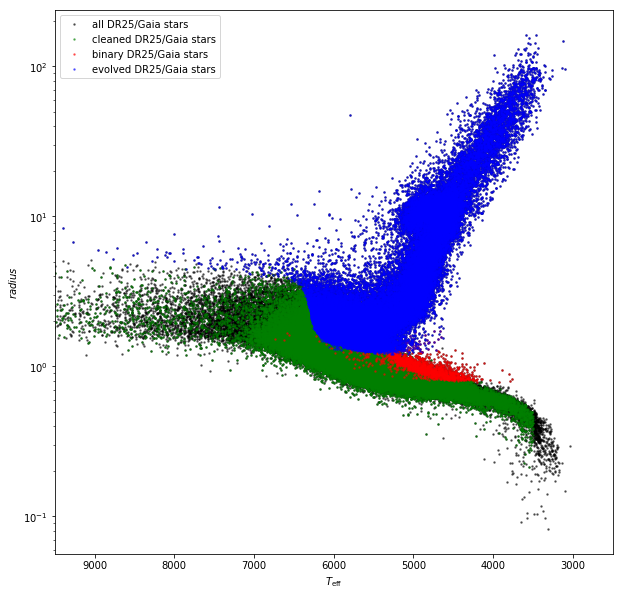

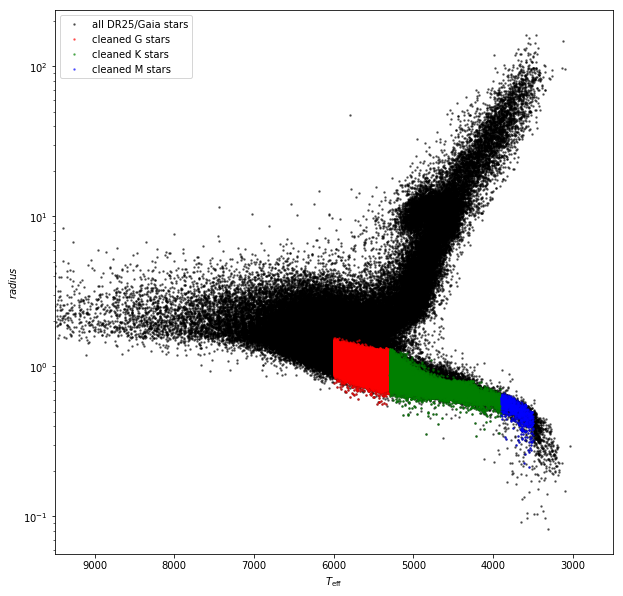

In [26]:

if (catalogType == "Berger2019"):
    plt.figure(figsize=(10,10));
    plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
    plt.semilogy(cleanDr25GaiaStellar.teff, cleanDr25GaiaStellar["R*"], ".g", ms=3, alpha=0.5)
    plt.semilogy(binaryDr25GaiaStellar.teff, binaryDr25GaiaStellar["R*"], ".r", ms=3, alpha=0.5)
    plt.semilogy(evolvedDr25GaiaStellar.teff, evolvedDr25GaiaStellar["R*"], ".b", ms=3, alpha=0.5)
    plt.xlim(9500, 2500)
    plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars", "binary DR25/Gaia stars", "evolved DR25/Gaia stars"));
    plt.ylabel("$radius$");
    plt.xlabel("$T_\mathrm{eff}$");

plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarG.teff, cleanDr25GaiaStellarG["R*"], ".r", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarK.teff, cleanDr25GaiaStellarK["R*"], ".g", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarM.teff, cleanDr25GaiaStellarM["R*"], ".b", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned G stars", "cleaned K stars", "cleaned M stars"));
plt.ylabel("$radius$");
plt.xlabel("$T_\mathrm{eff}$");



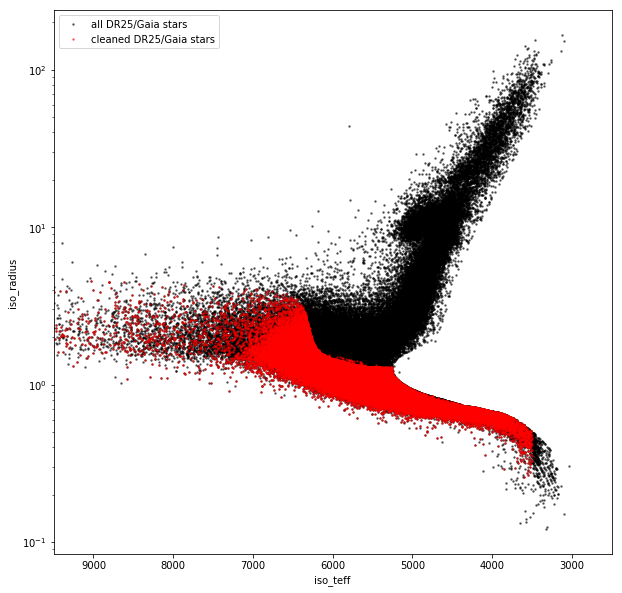

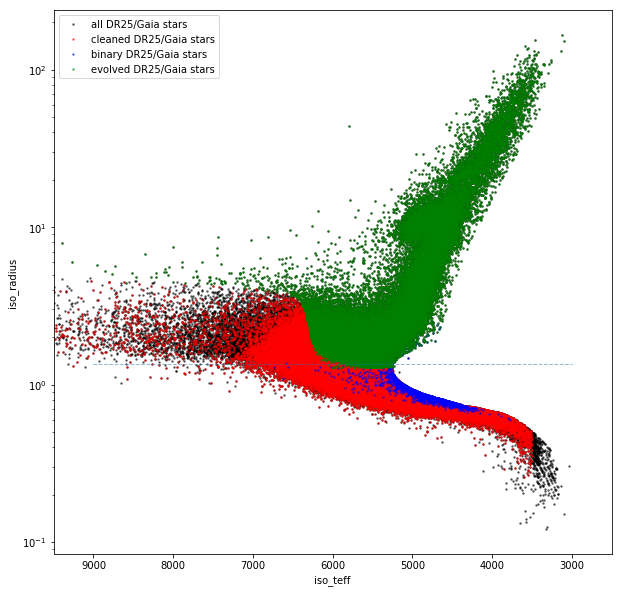

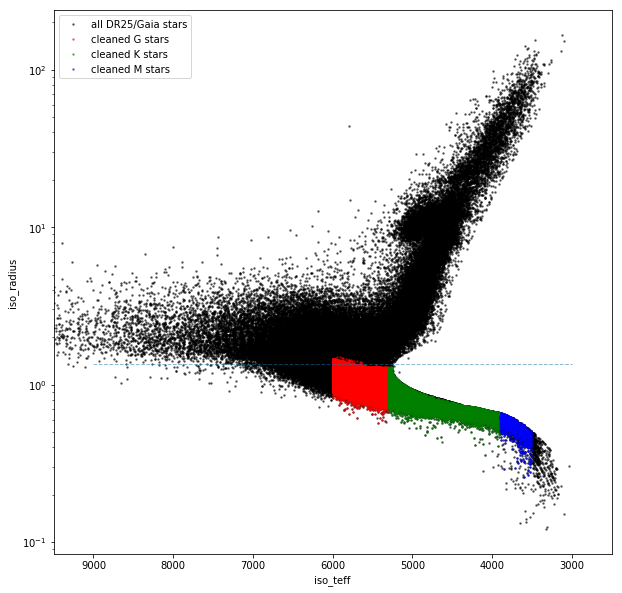

In [27]:
plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.iso_teff, dr25GaiaStellar.iso_rad, ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellar.iso_teff, cleanDr25GaiaStellar.iso_rad, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars"));
plt.ylabel("iso_radius");
plt.xlabel("iso_teff");

if (catalogType == "Berger2019"):
    plt.figure(figsize=(10,10));
    plt.semilogy(dr25GaiaStellar.iso_teff, dr25GaiaStellar.iso_rad, ".k", ms=3, alpha=0.5)
    plt.semilogy(cleanDr25GaiaStellar.iso_teff, cleanDr25GaiaStellar.iso_rad, ".r", ms=3, alpha=0.5)
    plt.semilogy(binaryDr25GaiaStellar.iso_teff, binaryDr25GaiaStellar.iso_rad, ".b", ms=3, alpha=0.5)
    plt.semilogy(evolvedDr25GaiaStellar.iso_teff, evolvedDr25GaiaStellar.iso_rad, ".g", ms=3, alpha=0.5)
    plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
    plt.xlim(9500, 2500)
    plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars", "binary DR25/Gaia stars", "evolved DR25/Gaia stars"));
    plt.ylabel("iso_radius");
    plt.xlabel("iso_teff");

plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar.radius, ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarG.iso_teff, cleanDr25GaiaStellarG.iso_rad, ".r", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarK.iso_teff, cleanDr25GaiaStellarK.iso_rad, ".g", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarM.iso_teff, cleanDr25GaiaStellarM.iso_rad, ".b", ms=3, alpha=0.5)
plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned G stars", "cleaned K stars", "cleaned M stars"));
plt.ylabel("iso_radius");
plt.xlabel("iso_teff");



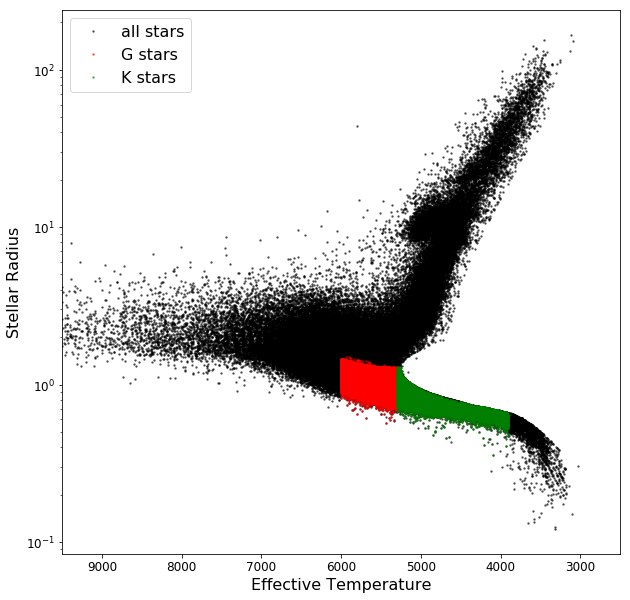

In [28]:
ax = plt.figure(figsize=(10,10));
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar.radius, ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarG.iso_teff, cleanDr25GaiaStellarG.iso_rad, ".r", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarK.iso_teff, cleanDr25GaiaStellarK.iso_rad, ".g", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all stars", "G stars", "K stars"), fontsize = 16);
plt.ylabel("Stellar Radius", fontsize = 16);
plt.xlabel("Effective Temperature", fontsize = 16);
# ax.tick_params(axis = "both", labelsize = 12)
plt.tick_params(labelsize = 12)
plt.savefig("stellarPopulation.png",bbox_inches='tight')



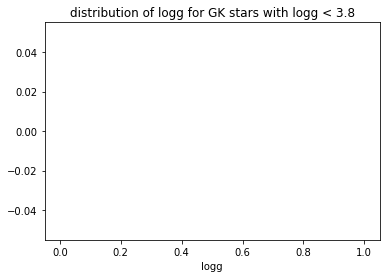

In [29]:
plt.hist(cleanDr25GaiaStellarGK["logg"][cleanDr25GaiaStellarGK["logg"]<3.8], 40);
plt.title("distribution of logg for GK stars with logg < 3.8")
plt.xlabel("logg");

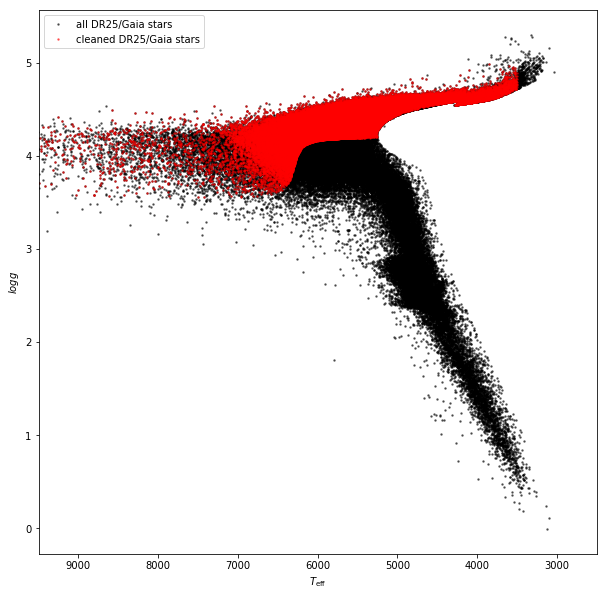

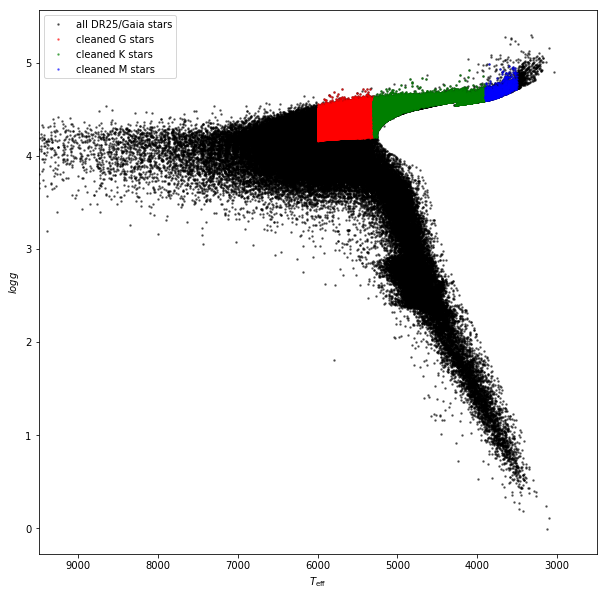

In [30]:

plt.figure(figsize=(10,10));
plt.plot(dr25GaiaStellar.teff, dr25GaiaStellar.logg, ".k", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellar.teff, cleanDr25GaiaStellar.logg, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars"));
plt.ylabel("$logg$");
plt.xlabel("$T_\mathrm{eff}$");

plt.figure(figsize=(10,10));
plt.plot(dr25GaiaStellar.teff, dr25GaiaStellar.logg, ".k", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarG.teff, cleanDr25GaiaStellarG.logg, ".r", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarK.teff, cleanDr25GaiaStellarK.logg, ".g", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarM.teff, cleanDr25GaiaStellarM.logg, ".b", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned G stars", "cleaned K stars", "cleaned M stars"));
plt.ylabel("$logg$");
plt.xlabel("$T_\mathrm{eff}$");



In [37]:
np.max(cleanDr25GaiaStellarGK.radius)

1.4998271673705648

In [38]:
len(cleanDr25GaiaStellarGK[cleanDr25GaiaStellarGK.radius > 1.35])

1100

In [40]:
float(len(cleanDr25GaiaStellarGK[cleanDr25GaiaStellarGK.radius > 1.35]))/len(cleanDr25GaiaStellarGK)

0.017432370326936182

In [41]:
len(cleanDr25GaiaStellarGK)

63101

In [31]:
rr = cleanDr25GaiaStellarGK["R*"]/cleanDr25GaiaStellarGK.radius
print("mean rr " + str(np.mean(rr)))
print("median rr " + str(np.median(rr)))
print("std rr " + str(np.std(rr)))

mean rr 0.994108411502
median rr 0.9904675791423871
std rr 0.0254581058922


In [32]:
catalogName = catalogType
if doRadCut:
    catalogName = catalogName + "_radCut"

In [33]:
%%javascript
IPython.notebook.save_notebook()


<IPython.core.display.Javascript object>

In [34]:
%%bash -s "$catalogName"
jupyter nbconvert --to html createStellarCatalogs.ipynb
mv createStellarCatalogs.html createStellarCatalogs$1.html


[NbConvertApp] Converting notebook createStellarCatalogs.ipynb to html
[NbConvertApp] Writing 2147458 bytes to createStellarCatalogs.html


In [35]:
np.sum(np.isnan(cleanDr25GaiaStellarGK.limbdark_coeff4))

0

In [36]:
r = dr25GaiaStellar.limbdark_coeff1.values/dr25GaiaStellar.limbdark_coeff1_DR25.values
r = r[~np.isnan(r)]
r = r[np.isfinite(r)]
print("median ratio = " + str(np.median(r)) 
      + " mad = " + str(np.median(np.abs(r - np.median(r)))) 
      + " mean = " + str(np.mean(r))
      + " std = " + str(np.std(r)))

r = dr25GaiaStellar.limbdark_coeff2.values/dr25GaiaStellar.limbdark_coeff2_DR25.values
r = r[~np.isnan(r)]
r = r[np.isfinite(r)]
print("median ratio = " + str(np.median(r)) 
      + " mad = " + str(np.median(np.abs(r - np.median(r)))) 
      + " mean = " + str(np.mean(r))
      + " std = " + str(np.std(r)))

r = dr25GaiaStellar.limbdark_coeff3.values/dr25GaiaStellar.limbdark_coeff3_DR25.values
r = r[~np.isnan(r)]
r = r[np.isfinite(r)]
print("median ratio = " + str(np.median(r)) 
      + " mad = " + str(np.median(np.abs(r - np.median(r)))) 
      + " mean = " + str(np.mean(r))
      + " std = " + str(np.std(r)))

r = dr25GaiaStellar.limbdark_coeff4.values/dr25GaiaStellar.limbdark_coeff4_DR25.values
r = r[~np.isnan(r)]
r = r[np.isfinite(r)]
print("median ratio = " + str(np.median(r)) 
      + " mad = " + str(np.median(np.abs(r - np.median(r)))) 
      + " mean = " + str(np.mean(r))
      + " std = " + str(np.std(r)))




median ratio = 1.135107443010031 mad = 0.14669287382755603 mean = 1.2698489453166393 std = 8.758414487824234
median ratio = 0.7233380490510644 mad = 0.5111874593520725 mean = 0.4198041538642899 std = 38.90871555283477
median ratio = 0.9780313909508869 mad = 0.632460194843676 mean = 1.3712794483649036 std = 66.6984346886669
median ratio = 1.0229363258785273 mad = 0.5840621462728491 mean = 0.5964512877928226 std = 43.13814919554386


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in divide
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in divide
